In [202]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, vector_y = True)
#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, 2353) # 2844 total obs - 711 test, still 25% even without random split, last outbreak 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  date_format = "%Y-%m-%d"


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [131]:
import torch.nn as nn
import torch
from NegativeBinomial import NegBin as NB
from torch.distributions import Poisson as Poi
set_seeds(SEED)

## For matrix-like (two-dimensional) input data
class NowcastPNNIndivCounts(nn.Module):
    """ Still NowcastPNN, just this time predicting all individual delay counts as NB distribution.
    This means that there are `lambda` and `phi` for each delay count, and the loss is the log loss for all observations.
    In the end, the values are summed, where the available values (already observed) are fixed and kept in place """
    def __init__(self, past_units = 40, max_delay = 40, hidden_units = [24, 12, 4], conv_channels = [16, 2]):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.final_dim = past_units# * (2**len(conv_channels))
        self.conv1 = nn.Conv1d(self.max_delay, conv_channels[0], kernel_size=7, padding="same")
        self.conv2 = nn.Conv1d(conv_channels[0], conv_channels[1], kernel_size=7, padding="same")
        #self.conv3 = nn.Conv1d(conv_channels[1], conv_channels[2], kernel_size=7, padding="same")
        #self.conv4 = nn.Conv1d(conv_channels[2], conv_channels[3], kernel_size=7, padding="same")
        self.fc1 = nn.Linear(self.past_units, self.past_units)#, nn.Linear(self.past_units, self.past_units)
        self.fc3, self.fc4 = nn.Linear(self.past_units, hidden_units[0]), nn.Linear(hidden_units[0], hidden_units[1])#, nn.Linear(hidden_units[1], hidden_units[2])
        self.fc5 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fcnb = nn.Linear(hidden_units[-1], 2)
        #self.fcpoi = nn.Linear(hidden_units[-1], 1)
        self.const = 1000 # individual counts not in tens of thousands, but thousands only max, rather hundreds

        self.bnorm1, self.bnorm2 = nn.BatchNorm1d(num_features=self.max_delay), nn.BatchNorm1d(num_features=conv_channels[0])#, nn.BatchNorm1d(num_features=conv_channels[1])#, nn.BatchNorm1d(num_features=conv_channels[2])
        #self.bnorm3 = nn.BatchNorm1d(num_features=conv_channels[1])
        self.bnorm5, self.bnorm6  = nn.BatchNorm1d(num_features=self.max_delay), nn.BatchNorm1d(num_features=self.max_delay)#, nn.BatchNorm1d(num_features=hidden_units[2])
        self.bnorm7 = nn.BatchNorm1d(num_features=self.max_delay)
        self.bnorm_final = nn.BatchNorm1d(num_features=self.max_delay) #hidden_units[1]/self.past_units for single model
        self.attn1 = nn.MultiheadAttention(embed_dim=self.max_delay, num_heads=1, batch_first=True)
        self.drop1, self.drop2, self.drop3 = nn.Dropout(0.3), nn.Dropout(0.2), nn.Dropout(0.1) # optimal 0.15, 0.1 for random split 
        self.softplus = nn.Softplus()
        self.act = nn.SiLU()
    
    def forward(self, x): ## Feed forward function, takes input of shape [batch, past_units, max_delay]
        #x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = x.float()
        ## Attention Block ##
        x_add = x.clone()
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.act(self.fc1(x.permute(0,2,1)))
        x = x.permute(0,2,1) + x_add

        """## Convolutional Block ##
        x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = self.act(self.conv1(self.bnorm1(x)))
        x = self.act(self.conv2(self.bnorm2(x))) # [batch, 2, max_delay]
        #x = self.act(self.conv3(self.bnorm3(x)))
        #x = self.act(self.conv4(self.bnorm4(x)))
        #x = x.permute(0, 2, 1) # [batch, max_delay, 2], can think about leaving max delay as last to process"""

        ## Fully Connected Block ##
        #x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = self.drop1(x)
        x = self.act(self.fc3(self.bnorm5(x)))
        x = self.drop2(x)
        x = self.act(self.fc4(self.bnorm6(x)))
        x = self.drop3(x)
        x = self.act(self.fc5(self.bnorm7(x)))
        x = self.fcnb(self.bnorm_final(x))
        ## Need to output lambda nad phi for each batch for whole length
        ## Dim is [batch_size, 2, max_delay] or [batch_size, max_delay, 2]
        dist = NB(lbda = self.const*self.softplus(x[:, :, 0]), phi = (self.const**2)*self.softplus(x[:, :, 1])+1e-5)
        """
        x = self.fcpoi(self.bnorm_final(x))
        dist = Poi(rate=self.const*self.softplus(x)+1e-5)
        """
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)

In [132]:
%reload_ext autoreload
%autoreload 3
from train_utils import train, EarlyStopper
set_seeds(SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, state="SP", future_obs=0, triangle=TRIANGLE)
nowcast_pnn = NowcastPNNIndivCounts(past_units=PAST_UNITS, max_delay=MAX_DELAY)
#nowcast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-fut0-{STATE}"))

Epoch 1 - Train loss: 2.79e+04 - Val loss: 2.61e+04 - ES count: 0
Epoch 2 - Train loss: 2.18e+04 - Val loss: 1.98e+04 - ES count: 0
Epoch 3 - Train loss: 1.85e+04 - Val loss: 1.44e+04 - ES count: 0
Epoch 4 - Train loss: 1.63e+04 - Val loss: 1.25e+04 - ES count: 0
Epoch 5 - Train loss: 1.51e+04 - Val loss: 1.18e+04 - ES count: 0
Epoch 6 - Train loss: 1.49e+04 - Val loss: 1.11e+04 - ES count: 0
Epoch 7 - Train loss: 1.43e+04 - Val loss: 9.85e+03 - ES count: 0
Epoch 8 - Train loss: 1.24e+04 - Val loss: 8.86e+03 - ES count: 0
Epoch 9 - Train loss: 1.05e+04 - Val loss: 8.63e+03 - ES count: 0
Epoch 10 - Train loss: 9.38e+03 - Val loss: 8.63e+03 - ES count: 1
Epoch 11 - Train loss: 8.73e+03 - Val loss: 8.48e+03 - ES count: 0
Epoch 12 - Train loss: 8.26e+03 - Val loss: 7.94e+03 - ES count: 0
Epoch 13 - Train loss: 7.86e+03 - Val loss: 7.42e+03 - ES count: 0
Epoch 14 - Train loss: 7.46e+03 - Val loss: 7.04e+03 - ES count: 0
Epoch 15 - Train loss: 7.13e+03 - Val loss: 6.74e+03 - ES count: 0
Epoc

<All keys matched successfully>

In [203]:
from metrics import pnn_PIs_indiv, evaluate_PIs
set_seeds(SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn = pnn_PIs_indiv(nowcast_pnn, test_loader, random_split = RANDOM_SPLIT, save=False, future_obs=0) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn, test_loader, return_coverages=False, return_is_decomposed=False, total = False)

TypeError: NowcastPNNDOW.forward() missing 1 required positional argument: 'dow'

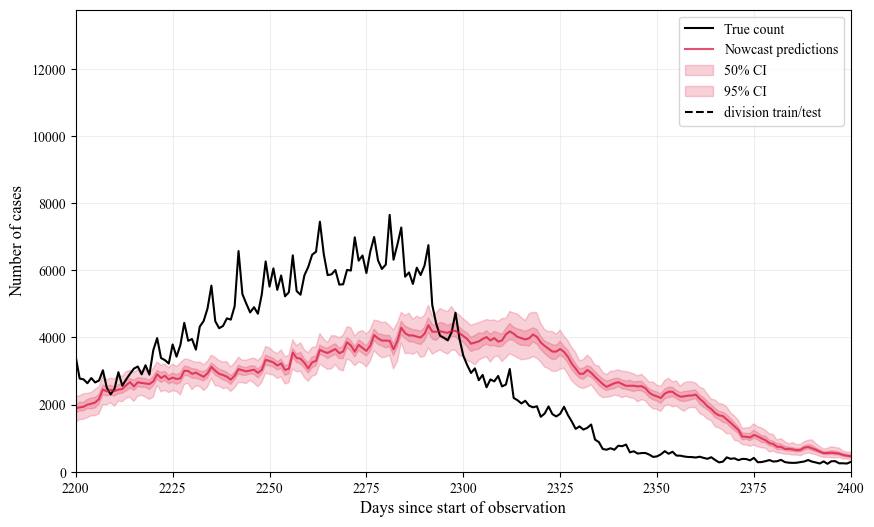

In [135]:
%reload_ext autoreload
%autoreload 3
from plotting import plot_entire_confints
set_seeds(SEED) # biggest outbreak 600, 900
plot_entire_confints(dataset, nowcast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, xlims = [2200, 2400], test_idcs=test_idcs, total = False)

# Old structure with day of week as input

In [1]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
import os
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"
DOW = True

dataset_dow = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, dow = DOW)
#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset_dow.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS:
        train_idcs, test_idcs = range(300), range(300, dataset_dow.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset_dow.__len__()) # 2844 total obs - 711 test, still 25% even without random split dataset.__len__(), 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler_dow, val_sampler_dow, test_sampler_dow = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader_dow, val_loader_dow, test_loader_dow = DataLoader(dataset_dow, batch_size=BATCH_SIZE, sampler=train_sampler_dow), DataLoader(dataset_dow, batch_size=VAL_BATCH_SIZE, sampler=val_sampler_dow, shuffle=False), DataLoader(dataset_dow, batch_size=TEST_BATCH_SIZE, sampler=test_sampler_dow, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader_dow
    train_loader_dow = DataLoader(dataset_dow, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def regen_loader(seed, dataset, batch_size, idcs):
    g = torch.Generator()
    g.manual_seed(seed)
    gen_loader = DataLoader(dataset, batch_size=batch_size, sampler = SRS(idcs, generator = g))
    return gen_loader

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seeds(SEED)


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [18]:
import torch.nn as nn
import torch
from NegativeBinomial import NegBin as NB
set_seeds(SEED)
## For matrix-like (two-dimensional) input data
class NowcastPNNDOW(nn.Module):
    """ Still NowcastPNN, just this time processing the day of the week additionally to reporting triangle """
    def __init__(self, past_units = 40, max_delay = 40, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 8):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.final_dim = past_units# * (2**len(conv_channels))
        self.conv1 = nn.Conv1d(self.max_delay, conv_channels[0], kernel_size=7, padding="same")
        self.conv2 = nn.Conv1d(conv_channels[0], conv_channels[1], kernel_size=7, padding="same")
        self.fc1 = nn.Linear(self.past_units, self.past_units)#, nn.Linear(self.past_units, self.past_units)
        self.fc3, self.fc4 = nn.Linear(self.final_dim, hidden_units[0]), nn.Linear(hidden_units[0], hidden_units[1])#, nn.Linear(hidden_units[1], hidden_units[2])
        #self.fc5 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fcnb = nn.Linear(hidden_units[-1], 2)
        #self.fcpoi = nn.Linear(hidden_units[-1], 1)
        self.const = 10000 # if not normalized, take constant out
        self.embedding_dim = embedding_dim
        self.embed = nn.Embedding(7, embedding_dim)
        #self.embed.weight = nn.Parameter(torch.randn((7, embedding_dim))), can use to initialize, doesn't help
        self.fc_embed1, self.fc_embed2 = nn.Linear(embedding_dim, 2*embedding_dim), nn.Linear(2*embedding_dim, past_units)
        #self.fc_embed1 = nn.Linear(embedding_dim, past_units)

        self.bnorm1, self.bnorm2 = nn.BatchNorm1d(num_features=self.max_delay), nn.BatchNorm1d(num_features=conv_channels[0])#, nn.BatchNorm1d(num_features=conv_channels[1])#, nn.BatchNorm1d(num_features=conv_channels[2])
        #self.bnorm3 = nn.BatchNorm1d(num_features=conv_channels[1])
        self.bnorm5, self.bnorm6  = nn.BatchNorm1d(num_features=self.final_dim), nn.BatchNorm1d(num_features=hidden_units[0])#, nn.BatchNorm1d(num_features=hidden_units[2])
        self.bnorm_embed1, self.bnorm_embed2 = nn.BatchNorm1d(num_features=embedding_dim), nn.BatchNorm1d(num_features=2*embedding_dim)
        #self.bnorm7 = nn.BatchNorm1d(num_features=hidden_units[1])
        self.bnorm_final = nn.BatchNorm1d(num_features=hidden_units[-1]) #hidden_units[1]/self.past_units for single model
        self.attn1 = nn.MultiheadAttention(embed_dim=self.max_delay, num_heads=1, batch_first=True)
        self.drop1, self.drop2 = nn.Dropout(0.3), nn.Dropout(0.1) 
        self.softplus = nn.Softplus()
        self.act = nn.SiLU()
    
    def forward(self, rep_tri, dow): ## Feed forward function, takes input of shape [batch, past_units, max_delay]
        #x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = rep_tri.float()

        ## Attention Block ##
        x_add = x.clone()
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.act(self.fc1(x.permute(0,2,1)))
        x = x.permute(0,2,1) + x_add

        ## Convolutional Block ##
        x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = self.act(self.conv1(self.bnorm1(x)))
        x = self.act(self.conv2(self.bnorm2(x)))
        #x = self.act(self.conv3(self.bnorm3(x)))
        #x = self.act(self.conv4(self.bnorm4(x)))
        x = torch.squeeze(x)

        ## Addition of embedding of day of the week ##
        embed = self.embed(dow)
        x = x + self.act(self.fc_embed2(self.bnorm_embed2(self.act(self.fc_embed1(self.bnorm_embed1(embed))))))
        
        ## Fully Connected Block ##
        x = self.drop1(x)
        x = self.act(self.fc3(self.bnorm5(x)))
        x = self.drop2(x)
        x = self.act(self.fc4(self.bnorm6(x)))
        #x = self.drop3(x)
        #x = self.act(self.fc5(self.bnorm7(x)))
        
        x = self.fcnb(self.bnorm_final(x))
        dist = NB(lbda = self.const*self.softplus(x[:, 0]), phi = (self.const**2)*self.softplus(x[:, 1])+1e-5)
        """
        x = self.fcpoi(self.bnorm_final(x))
        dist = Poi(rate=self.const*self.softplus(x)+1e-5)
        """
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)

In [22]:
%reload_ext autoreload
%autoreload 3
from train_utils import train, EarlyStopper
set_seeds(SEED) # reproducible training runs

## Reset the training loader twice to ensure each training run is identical
train_loader_dow = regen_loader(SEED, dataset_dow, BATCH_SIZE, train_idcs) # reset samplers so each training run is reproducible
regen_data()

early_stopper_dow = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, future_obs=0, random_split=RANDOM_SPLIT, dow = DOW)
nowcast_pnn_dow = NowcastPNNDOW(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(nowcast_pnn_dow, num_epochs=200, train_loader=train_loader_dow, val_loader=val_loader_dow, early_stopper=early_stopper_dow, loss_fct="nll", device = DEVICE, dow = DOW)

## Load best set of weights on test/validation set
nowcast_pnn_dow.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}"))

Epoch 1 - Train loss: 2.66e+05 - Val loss: 2.24e+06 - ES count: 0
Epoch 2 - Train loss: 2.57e+05 - Val loss: 2.27e+06 - ES count: 1
Epoch 3 - Train loss: 2.51e+05 - Val loss: 1.99e+06 - ES count: 0
Epoch 4 - Train loss: 2.48e+05 - Val loss: 1.91e+06 - ES count: 0
Epoch 5 - Train loss: 2.43e+05 - Val loss: 1.86e+06 - ES count: 0
Epoch 6 - Train loss: 2.38e+05 - Val loss: 1.84e+06 - ES count: 0
Epoch 7 - Train loss: 2.35e+05 - Val loss: 1.79e+06 - ES count: 0
Epoch 8 - Train loss: 2.3e+05 - Val loss: 1.78e+06 - ES count: 0
Epoch 9 - Train loss: 2.26e+05 - Val loss: 1.68e+06 - ES count: 0
Epoch 10 - Train loss: 2.21e+05 - Val loss: 1.64e+06 - ES count: 0
Epoch 11 - Train loss: 2.16e+05 - Val loss: 1.64e+06 - ES count: 1


KeyboardInterrupt: 

2.24, 2.27, 1.99, 1.91, 1.86, 1.85, 1.79 | 2.24, 2.27, 1.99, 1.91, 1.87, 1.84, 1.79

In [18]:
from metrics import pnn_PIs, evaluate_PIs
set_seeds(SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn_dow = pnn_PIs(nowcast_pnn_dow, test_loader_dow, random_split = RANDOM_SPLIT, save=True, dow = DOW) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn_dow, test_loader_dow, return_coverages=False, return_is_decomposed=False)

Actual coverage per level | 5%: 7.03 | 10%: 13.92 | 25%: 32.07 | 50%: 59.92 | 75%: 82.7 | 90%: 92.26 | 95%: 94.66 |
PICA: 0.047498493068113316
CWC: 0.28915009899915173
WIS: 216.16996235705685
IS: 675.5050127663275
IS: under = 107.28406459185938 | spread = 432.9704038577456 | over = 135.2505443167224 | total = 675.5050127663275


WIS: 265.3938074143986
IS: 837.1670092072657

WIS: 216.08165905171583
IS: 682.0023872386075

WIS: 239.71446020074404
IS: 758.4782666347068

WIS: 214.96182106442066
IS: 674.9332819272747

WIS: 219.8409784423553
IS: 690.878608617183

WIS: 219.8409784423553
IS: 690.878608617183

WIS: 214.8541211805298
IS: 670.7584752140548

WIS: 227.96074105740203
IS: 716.6850715043586

WIS: 224.08087938973466
IS: 708.6389561867633

WIS: 220.29177706974497
IS: 694.6943683341029

WIS: 228.99985482586362
IS: 716.6771037709134

WIS: 216.16996235705685
IS: 675.5050127663275


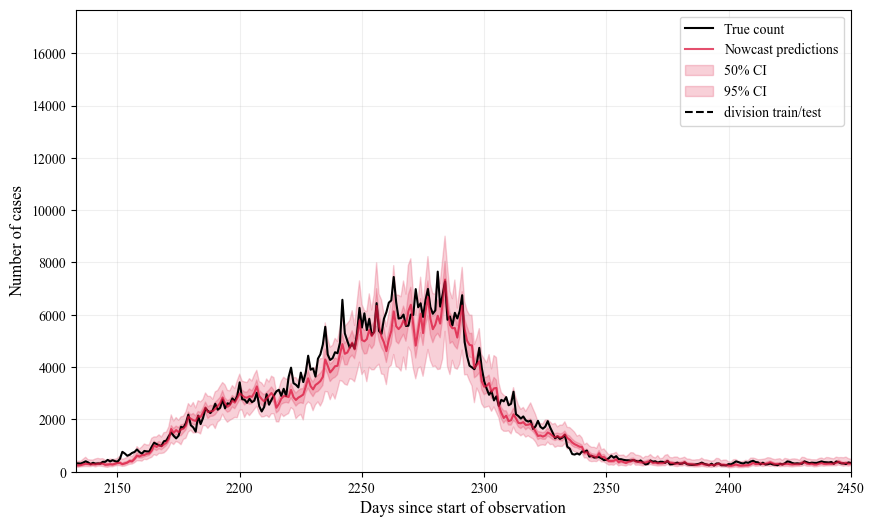

In [14]:
%reload_ext autoreload
%autoreload 3
from plotting import plot_entire_confints
set_seeds(SEED) # biggest outbreak 700, 900
plot_entire_confints(dataset, nowcast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, xlims = [2133, 2450], test_idcs=test_idcs, dow = DOW)